<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/ai_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<S&P 500 지수를 학습하여, 20일 주가흐름으로 다음날에 오를지 내릴지 예측>

2022.4.10.<br>

Author: 공대현 (학번: 120210117)<br>

S&P는 데이터 크롤링이 안되어서, 지수 추종 ETF인 SPY를 사용하였음

데이터 크롤링은 해외주식 크롤링이가능한 finance-datareader을 import해서 하였음

# 1. Import

In [1]:
!pip install finance-datareader
!pip install pyts
!pip install fastai --upgrade
!pip install fastbook --upgrade

     |████████████████████████████████| 48 kB 2.1 MB/s 
     |████████████████████████████████| 2.5 MB 5.0 MB/s 
     |████████████████████████████████| 188 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 720 kB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 23.9 MB/s 
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 561 kB 49.2 MB/s 
     |████████████████████████████████| 130 kB 54.2 MB/s 
     |████████████████████████████████| 428 kB 28.7 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing inst

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
import FinanceDataReader as fdr
import os

# 2. Data preparation

In [3]:
# S&P 지수 1997~2016년을 train으로 load
# S&P 지수 2017~2022년를 test로 load

train_df = fdr.DataReader('SPY', '1997','2016')
test_df = fdr.DataReader('SPY', '2017','2022')

In [4]:
# check dtypes of variables
print(train_df.dtypes)
train_df

Close     float64
Open      float64
High      float64
Low       float64
Volume    float64
Change    float64
dtype: object


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1997-01-02,74.03,74.38,74.38,72.75,2030000.0,0.0026
1997-01-03,75.09,74.38,75.12,74.08,2120000.0,0.0143
1997-01-06,74.44,75.09,75.44,74.31,1370000.0,-0.0087
1997-01-07,75.34,74.44,75.47,74.12,939000.0,0.0121
1997-01-08,74.69,75.75,75.78,74.69,1800000.0,-0.0086
...,...,...,...,...,...,...
2015-12-24,205.68,205.72,206.33,205.42,48540000.0,-0.0017
2015-12-28,205.21,204.86,205.26,203.94,65900000.0,-0.0023
2015-12-29,207.40,206.51,207.79,206.47,92640000.0,0.0107


전날대비 변동: 0.0129


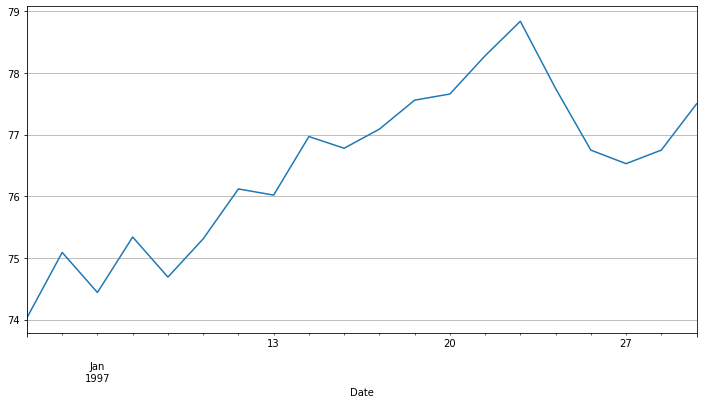

In [7]:
## S&P 20일의 종가 그래프와 다음날 주가 변화
x_data = train_df[0:20]['Close']
x_data.plot(figsize=(12,6), grid=True);
print('전날대비 변동:',train_df['Change'][20])

In [ ]:
## train 데이터 생성
i = 0
train_label_list = []

while True:
  ## change <= 0 이면 하락 [label = 0] , change> 0 이면 상승 [label = 1]
  try:
    change = train_df.iloc[i+20]['Change']
  except:
    break
  if change <= 0 :
    label = 0
  if change > 0 :
    label = 1
  train_label_list.append(label)

  ## 하루씩 밀려가며 20일치 종가('Close') 그래프를 new_data에 저장
  x_data = train_df[i:i+20]['Close'].values
    ## 0~1값으로 주가 normalizing
  min_value = min(x_data)
  max_value = max(x_data)
  x_data = np.array([(x_data - min_value) / (max_value - min_value)])
  if i == 0 :
    train_data = np.array(x_data)
  else:
    train_data = np.concatenate((train_data,np.array(x_data)),axis=0)

  i += 1
# train_data

In [ ]:
## test 데이터 생성
i = 0
test_label_list = []
while True:
  ## change <= 0 이면 하락 [label = 0] , change> 0 이면 상승 [label = 1]
  try:
    change = test_df.iloc[i+20]['Change']
  except:
    break
  if change <= 0 :
    label = 0
  if change > 0 :
    label = 1
  test_label_list.append(label)

  ## 하루씩 밀려가며 20일치 종가 그래프를 new_data에 저장
  x_data = test_df[i:i+20]['Close'].values
    ## 0~1값으로 주가 normalizing  
  min_value = min(x_data)
  max_value = max(x_data)
  x_data = np.array([(x_data - min_value) / (max_value - min_value)])

  if i == 0 :
    test_data = np.array(x_data)
  else:
    test_data = np.concatenate((test_data,np.array(x_data)),axis=0)

  i += 1

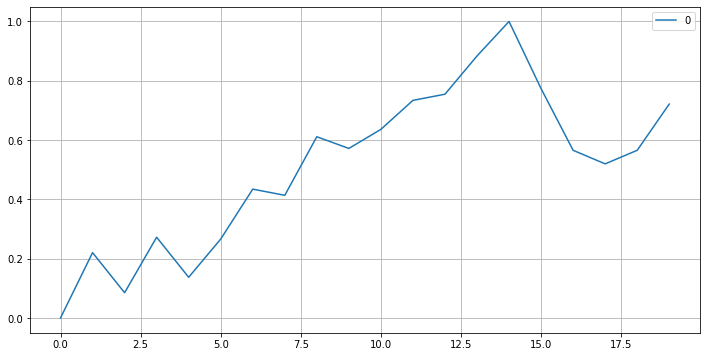

In [ ]:
## data normalize 확인
pd.DataFrame(train_data[0]).plot(figsize=(12,6), grid=True);

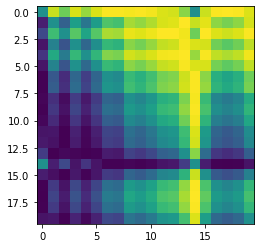

In [ ]:
## train_data , test_data GAF를 이용하여 이미지화
from pyts.image import GramianAngularField
from matplotlib.pyplot import imshow
transformer = GramianAngularField(method='difference')
X_train_GAF = transformer.fit_transform(train_data)
X_test_GAF = transformer.fit_transform(test_data)
imshow(X_train_GAF[0])

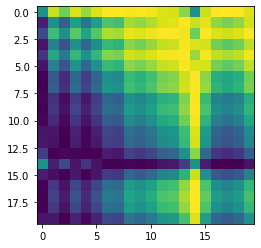

In [ ]:
# GAF 이미지 normalize
X_train_GAF_L = (((X_train_GAF + 1) / 2)*255).astype(int)
X_test_GAF_L = (((X_test_GAF + 1) / 2)*255).astype(int)
imshow(X_train_GAF_L[0])

In [ ]:
## GAF 이미지 normalize 확인

np.min(X_train_GAF_L), np.max(X_train_GAF_L)

(0, 255)

In [ ]:
## data 저장 폴더 생성

!mkdir gaf_images
root_folder = 'gaf_images'

mkdir: cannot create directory ‘gaf_images’: File exists


In [ ]:
# train / test data check
print(len(train_label_list))
print(len(test_label_list))

4762
1239


# 3. Train (fit)

In [ ]:
# save train set images (e.g., train/class_name/0.png)

for i in range(len(train_label_list)):
     
    # define file names
    image_file_name = str(i) + '.png'

    # define folder names
    class_folder_name = str(train_label_list[i])
    full_path = os.path.join(root_folder, 'train')
    full_path = os.path.join(full_path, class_folder_name)
    
    # make folders
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # save images
    image_file_name_with_full_path = os.path.join(full_path, image_file_name)
    plt.imsave(image_file_name_with_full_path, X_train_GAF_L[i])

In [ ]:
# save test set images (e.g., test/class_name/0.png)

for i in range(len(test_label_list)):
     
    # define file names
    image_file_name = str(i) + '.png'

    # define folder names
    class_folder_name = str(test_label_list[i])
    full_path = os.path.join(root_folder, 'test')
    full_path = os.path.join(full_path, class_folder_name)
    
    # make folders
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # save images
    image_file_name_with_full_path = os.path.join(full_path, image_file_name)
    plt.imsave(image_file_name_with_full_path, X_test_GAF_L[i])

# 4. Predict future

In [ ]:
# data block settings

my_random_seed = 32
my_batch_size = 32

In [ ]:
from fastai.vision.data import ImageDataLoaders
from fastai import *

In [ ]:
data = ImageDataLoaders.from_folder(
    root_folder, train="train", valid='test',
    seed=my_random_seed, bs=my_batch_size)

In [ ]:
len(data.train_ds), len(data.valid_ds)

(4762, 1239)

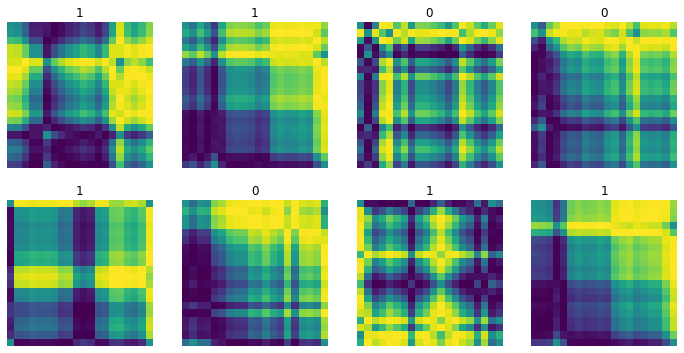

In [ ]:
# show image examples

data.show_batch(max_n=8, nrows=2)

In [ ]:
# resnet50으로 accuracy 확인
from fastbook import *
from fastai.vision.widgets import *
learn = cnn_learner(data, resnet50, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),SaveModelCallback(monitor='valid_loss')])

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,1.178328,1.102946,0.509282,01:47


Better model found at epoch 0 with valid_loss value: 1.1029456853866577.


epoch,train_loss,valid_loss,accuracy,time
0,0.835080,1.038121,0.534302,03:00
1,0.772591,0.717797,0.502018,03:07
2,0.755226,0.712284,0.516546,02:59
3,0.731054,0.715957,0.522195,03:01
4,0.718049,0.740570,0.498789,02:59
5,0.683480,0.733032,0.510896,03:01


Better model found at epoch 0 with valid_loss value: 1.0381206274032593.
Better model found at epoch 1 with valid_loss value: 0.7177972793579102.
Better model found at epoch 2 with valid_loss value: 0.7122844457626343.
No improvement since epoch 2: early stopping


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


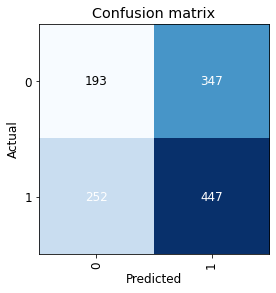

In [ ]:
# Confusion matrix 확인
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
## 실험 결과 51.6%
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


(#2) [0.7122844457626343,0.5165455937385559]

# 결론

#### 상승으로 예측 : 하락으로 예측 = 894 : 445
#### 실제 상승 : 실제 하락 699 : 540

#### 상승으로 예측하는 경우가 더 많았고, 한쪽으로 과하게 치우치지 않는 것으로 보아 overfitting이 많이 되진 않아보임

### 성능이 51%의 의미 100일 중 51일은 이득 49일은 하락이므로 결과적으로 약간의 이득을 챙길 수 있는 정도

#### 성능이 저조한 이유 : 주가는 과거의 주가 변화 말고도 금리 인상, 채권 가격, 거래량, 기업별 실적 등에 영향을 받으므로 그 부분들에 대해서도 고려가 되어야 함